<a href="https://colab.research.google.com/github/VerebicsPeter/CodeSim/blob/main/model/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Similarity with Contrastive Learning

## Dependencies

In [1]:
!pip install python-minifier  # for data augmentation
!pip install pytorch-metric-learning

In [2]:
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd
import pprint as pp
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from pytorch_metric_learning import losses
# Hugging Face Transformers (CodeBERT etc.)
import transformers
from transformers import AutoTokenizer, AutoModel
# Libraries for augmenting data
import python_minifier
# Libraries for logging
from tqdm.auto import tqdm
from typing import Iterable

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

Device: cuda
Tesla T4


## Dataset Access

In [4]:
from google.colab import userdata
labeled_dataset_url = f"https://drive.google.com/uc?export=download&id={userdata.get('labeledDataset')}"
unlabeled_dataset_url = f"https://drive.google.com/uc?export=download&id={userdata.get('unlabeledDataset')}"

## Dataset and Data Augmentation

In [15]:
# Code datasets (for labeled and unlabeled code snippets)


def numeric_labels(labels: Iterable[str]) -> torch.Tensor:
    """Transform string labels to int labels for the NTXent loss function."""
    pos_labels = [ label for label in labels if label.endswith('1') ]
    labels_map = { label: i for i,label in enumerate(sorted(set(pos_labels))) }
    int_labels = [ labels_map.get(label, -1) for label in labels ]
    int_labels = torch.Tensor(int_labels)
    neg_indices = (int_labels == -1).nonzero(as_tuple=True)[0]
    M = max(int_labels)
    int_labels[neg_indices] = torch.arange(M + 1, M + 1 + len(neg_indices))
    return int_labels


def get_batch_encodings(
    codes: Iterable[str],
    tokenizer: transformers.PreTrainedTokenizer | transformers.PreTrainedTokenizerFast,
    device: str = "cpu"
) -> transformers.BatchEncoding:
    MAX_LEN = tokenizer.model_max_length
    inputs = tokenizer(
        codes,
        truncation=True,
        # Pad to "MAX_LEN + 1" to detect sequences that are too long
        padding="max_length", max_length=MAX_LEN + 1,
        return_tensors="pt",
    )

    # Mask sequences that are longer than "MAX_LEN"
    l_mask = inputs["attention_mask"].sum(dim=1) <= MAX_LEN

    inputs = { k: v[l_mask, :MAX_LEN] for k, v in inputs.items() }
    # Move tensors to the specified device
    inputs = { k: v.to(device) for k, v in inputs.items() }

    return inputs


class LabeledCodeDataset(Dataset):
    def __init__(
        self,
        tokenizer: transformers.PreTrainedTokenizer | transformers.PreTrainedTokenizerFast,
        codes : Iterable[str],
        labels: Iterable[str]
    ):
        assert len(codes) == len(labels)
        self.inputs = get_batch_encodings(codes, tokenizer, device)
        self.labels = numeric_labels(labels)

    def __getitem__(self, idx):
        input = {k: v[idx] for k, v in self.inputs.items()}
        label = self.labels[idx]
        return input, label

    def __len__(self):
        return self.inputs['input_ids'].shape[0]

    @classmethod
    def from_csv_data(cls, path: str, tokenizer, sample_size=0):
        df = pd.read_csv(path)
        print(df.shape)

        if sample_size:
            print('sampling dataframe...')
            df = df.sample(sample_size, ignore_index=True)
            print(df.shape)

        codes = df['source']
        codes = codes.to_list()

        labels = df['label']
        labels = labels.to_list()

        return cls(tokenizer, codes, labels)


class UnlabeledCodeDataset(Dataset):
    def __init__(
        self,
        tokenizer: transformers.PreTrainedTokenizer | transformers.PreTrainedTokenizerFast,
        ref_codes: Iterable[str],
        aug_codes: Iterable[str],
    ):
        assert len(ref_codes) == len(aug_codes)
        self.ref_inputs = get_batch_encodings(ref_codes, tokenizer, device)
        self.aug_inputs = get_batch_encodings(aug_codes, tokenizer, device)

    def __getitem__(self, idx):
        # Return both reference and augmented code inputs for a given index
        ref_input = {k: v[idx] for k, v in self.ref_inputs.items()}
        aug_input = {k: v[idx] for k, v in self.aug_inputs.items()}
        return ref_input, aug_input

    def __len__(self):
        return self.ref_inputs["input_ids"].shape[0]

    @classmethod
    def from_csv_data(cls, path: str, tokenizer, aug_func, sample_size=0):
        df = pd.read_csv(path)
        print(df.shape)

        if sample_size:
            print('sampling dataframe...')
            df = df.sample(sample_size, ignore_index=True)
            print(df.shape)

        ref_codes = df['file_content']
        aug_codes = df['file_content'].apply(aug_func)

        return cls(tokenizer, ref_codes.to_list(), aug_codes.to_list())

In [6]:
def minify(code: str) -> str:
    try: return python_minifier.minify(code)
    except Exception as error:
        #print(f'Error while minifying: {error}')  # TODO: use a log file for this
        pass
    return code

## Model

In [7]:
# Model

IS_SELF_SUPERVISED = False


def embedding_pipeline(transformer):
    """Create an embedding function with a `tokenizer` and `transformer`."""
    def pipeline(inputs: transformers.BatchEncoding):
        with torch.device(device):
            return transformer(**inputs)
    return pipeline


class CodeSimilarityModel(nn.Module):
    def __init__(self,
        embedding_pipeline,
        in_feat=768,  # depends on the embedding pipeline
        mlp_sizes=(256, 128),
        out_feat=32,
        dropout_rate=0.2,
    ):
        super().__init__()
        self.embedding_pipeline = embedding_pipeline
        self.in_feat = in_feat
        # Non linearity
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)
        # MLP 'projection head'
        mlp_layers = []
        mlp_layers.append(nn.Linear(in_feat, mlp_sizes[0]))

        mlp_layers.extend([self.relu, self.drop])
        mlp_layers.append(nn.Linear(mlp_sizes[0], mlp_sizes[1]))

        mlp_layers.extend([self.relu, self.drop])
        mlp_layers.append(nn.Linear(mlp_sizes[1], out_feat))

        self.mlp = nn.Sequential(*mlp_layers)


    def embed(self, inputs: transformers.BatchEncoding) -> torch.Tensor:
        output = self.embedding_pipeline(inputs)
        return output.pooler_output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.device(device):
            # pass through linear layers
            x = self.mlp(x)
            return x

## NTXent Loss Function

In [8]:
ntxent_loss = losses.NTXentLoss(temperature=0.5)
# Wrap the NTXent loss function if needed
ntxent_loss = losses.SelfSupervisedLoss(ntxent_loss) if IS_SELF_SUPERVISED else ntxent_loss

## Training Loop

In [9]:
# Training loop for the NTXEnt loss function

def compute_loss(batched_data, model, loss_func):
    """Computes the loss value for a batch of data."""
    if isinstance(loss_func, losses.SelfSupervisedLoss):
        ref_input, aug_input = batched_data
        ref_emb = model.embed(ref_input)  # transformer
        aug_emb = model.embed(aug_input)  # transformer
        ref_emb = model(ref_emb)  # MLP
        aug_emb = model(aug_emb)  # MLP
        loss = loss_func(ref_emb, aug_emb)
        return loss
    else:
        inputs, labels = batched_data
        embeddings = model.embed(inputs)  # transformer
        embeddings = model(embeddings)  # MLP
        loss = loss_func(embeddings, labels)
        return loss


def train_epoch(
    model: CodeSimilarityModel,
    loader: DataLoader,
    loss_func,
    optimizer,
    epochs: int = 0,  # number of epochs so far (for logging)
    writer: SummaryWriter | None = None,  # for logging loss values
):
    """Trains the model for one epoch."""

    def get_last_loss(n_batches, c_batches, batch, acc_loss):
        if batch % c_batches == c_batches - 1:
            return 0, acc_loss / c_batches
        elif batch == N_BATCHES - 1:
            return 0, acc_loss / (n_batches % c_batches)
        return acc_loss, 0

    def write_loss(writer, n_batches, batch, last_loss):
        # Log the average loss over the last  batches
        # TODO: use a log file for this
        print('',f'Batch: {batch + 1}/{n_batches}, Loss: {last_loss}')
        if writer is not None:
            writer.add_scalar("loss/train", last_loss, epochs * n_batches + batch + 1)

    model.train()  # Set the model to training mode
    N_BATCHES = len(loader)  # Number of batches
    C_BATCHES = 50  # Number of batches over which the logged loss is cumulated
    sum_loss = 0  # Loss accumulated per EPOCH
    acc_loss = 0  # Loss accumulated per last 25 batches
    progress_bar = tqdm(range(N_BATCHES))
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        loss = compute_loss(data, model, loss_func)
        # Adjust the weights
        loss.backward()
        optimizer.step()
        # Increase loss accumulator
        loss_val = loss.item()
        acc_loss += loss_val; sum_loss += loss_val
        # Update the loss accumulator and log the last loss
        progress_bar.update(1)
        acc_loss, last_loss = get_last_loss(N_BATCHES, C_BATCHES, i, acc_loss)
        if last_loss: write_loss(writer, N_BATCHES, i, last_loss)
    # Return the average loss in the epoch
    avg_loss = sum_loss / N_BATCHES
    return avg_loss


def validate(
    model: CodeSimilarityModel,
    loader: DataLoader,
    loss_func,
):
    """Validates the model for one epoch."""
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        sum_loss = 0
        for data in loader:
            loss = compute_loss(data, model, loss_func)
            sum_loss += loss.item()
        avg_loss = sum_loss / len(loader)
        return avg_loss


def train(
    model: CodeSimilarityModel,
    dataloaders,
    loss_func,
    optimizer,
    scheduler,
    epochs: int = 5,
):
    writer = None #SummaryWriter()
    tLosses, vLosses = [], []
    training_loader, validation_loader = dataloaders
    for epoch in range(epochs):
        print(f'EPOCH {epoch + 1}/{epochs}')
        # Train then validate
        avg_tLoss = train_epoch(model, training_loader, loss_func, optimizer, epoch, writer)
        avg_vLoss = validate(model, validation_loader, loss_func)
        # Adjust the LR scheduler
        if scheduler is not None:
            scheduler.step()
        # Log the losses
        print(f"EPOCH {epoch + 1}/{epochs}, AVG loss: {avg_tLoss}, AVG validation loss: {avg_vLoss}")
        tLosses.append(avg_tLoss)
        vLosses.append(avg_vLoss)
    if writer is not None:
        writer.close()
    return tLosses, vLosses

## Training

In [10]:
PRETRAINED_MODEL="neulab/codebert-python"
"""
Other models:
 "microsoft/codebert-base"
 "huggingface/CodeBERTa-small-v1"
"""

# Tokenizer is created first for preprocessing
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
# Create the dataset

SAMPLE_SIZE = 25_000

if IS_SELF_SUPERVISED:
    dataset = UnlabeledCodeDataset.from_csv_data(
        path=unlabeled_dataset_url,
        tokenizer=tokenizer,
        sample_size=SAMPLE_SIZE,
        aug_func=minify
    )
else:
    dataset = LabeledCodeDataset.from_csv_data(
        path=labeled_dataset_url,
        tokenizer=tokenizer,
        sample_size=SAMPLE_SIZE
    )

(34806, 3)
sampling dataframe...
(25000, 3)


In [17]:
len(dataset)

21631

In [18]:
# Split the data
tsize = int(0.8 * len(dataset))
vsize = len(dataset) - tsize
training_data, validation_data = random_split(dataset, [tsize, vsize])

In [19]:
# Create the data loaders

# NOTE: Bigger batch size generally leads to better results in contrastive learning
BATCH_SIZE = 12
SHUFFLE = True

training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
validation_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [20]:
# Create embedding pipeline, model, optimizer and scheduler

transformer = AutoModel.from_pretrained(PRETRAINED_MODEL).to(device)
transformer.eval()

emb_pipeline = embedding_pipeline(transformer)

model = CodeSimilarityModel(emb_pipeline).to(device)
m_optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
m_scheduler = torch.optim.lr_scheduler.StepLR(m_optimizer, step_size=4, gamma=0.1)

Some weights of RobertaModel were not initialized from the model checkpoint at neulab/codebert-python and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Train the model
losses = train(
    model,
    dataloaders=(training_loader, validation_loader),
    loss_func=ntxent_loss,
    optimizer=m_optimizer,
    scheduler=m_scheduler,
    epochs=4
)

EPOCH 1/4


  0%|          | 0/1442 [00:00<?, ?it/s]

 Batch: 50/1442, Loss: 0.18870648860931397
 Batch: 100/1442, Loss: 0.3791560840606689
 Batch: 150/1442, Loss: 0.530309853553772
 Batch: 200/1442, Loss: 0.4380500841140747
 Batch: 250/1442, Loss: 0.4227453756332398
 Batch: 300/1442, Loss: 0.19492067337036134
 Batch: 350/1442, Loss: 0.6744783926010132
 Batch: 400/1442, Loss: 0.42757229804992675
 Batch: 450/1442, Loss: 0.38652010917663576
 Batch: 500/1442, Loss: 0.4327798652648926
 Batch: 550/1442, Loss: 0.385324501991272
 Batch: 600/1442, Loss: 0.3789084100723267
 Batch: 650/1442, Loss: 0.3305200099945068
 Batch: 700/1442, Loss: 0.33364627838134764
 Batch: 750/1442, Loss: 0.24334193706512453
 Batch: 800/1442, Loss: 0.5817442274093628
 Batch: 850/1442, Loss: 0.23930420875549316
 Batch: 900/1442, Loss: 0.4375461530685425
 Batch: 950/1442, Loss: 0.2379564905166626
 Batch: 1000/1442, Loss: 0.3356373453140259
 Batch: 1050/1442, Loss: 0.2414382266998291
 Batch: 1100/1442, Loss: 0.48181806564331053
 Batch: 1150/1442, Loss: 0.6143286657333374
 B

  0%|          | 0/1442 [00:00<?, ?it/s]

 Batch: 50/1442, Loss: 0.48358973503112795
 Batch: 100/1442, Loss: 0.5249010276794434
 Batch: 150/1442, Loss: 0.2888899612426758
 Batch: 200/1442, Loss: 0.382808575630188
 Batch: 250/1442, Loss: 0.5776543474197388
 Batch: 300/1442, Loss: 0.3847661542892456
 Batch: 350/1442, Loss: 0.33873790740966797
 Batch: 400/1442, Loss: 0.3390371894836426
 Batch: 450/1442, Loss: 0.24380601882934572
 Batch: 500/1442, Loss: 0.24843902111053467
 Batch: 550/1442, Loss: 0.4343320655822754
 Batch: 600/1442, Loss: 0.28398359775543214
 Batch: 650/1442, Loss: 0.7290492153167725
 Batch: 700/1442, Loss: 0.3390295791625977
 Batch: 750/1442, Loss: 0.4781984329223633
 Batch: 800/1442, Loss: 0.3323149061203003
 Batch: 850/1442, Loss: 0.6673140239715576
 Batch: 900/1442, Loss: 0.42776081085205075
 Batch: 950/1442, Loss: 0.5293233823776246
 Batch: 1000/1442, Loss: 0.23995311737060546
 Batch: 1050/1442, Loss: 0.388621883392334
 Batch: 1100/1442, Loss: 0.23870712280273437
 Batch: 1150/1442, Loss: 0.5318951416015625
 B

  0%|          | 0/1442 [00:00<?, ?it/s]

 Batch: 50/1442, Loss: 0.2355154800415039
 Batch: 100/1442, Loss: 0.28796700000762937
 Batch: 150/1442, Loss: 0.33151681423187257
 Batch: 200/1442, Loss: 0.3837150764465332
 Batch: 250/1442, Loss: 0.24168849468231202
 Batch: 300/1442, Loss: 0.3839277696609497
 Batch: 350/1442, Loss: 0.2900192165374756
 Batch: 400/1442, Loss: 0.38649051666259765
 Batch: 450/1442, Loss: 0.4280391550064087
 Batch: 500/1442, Loss: 0.3308958911895752
 Batch: 550/1442, Loss: 0.4250065088272095
 Batch: 600/1442, Loss: 0.24707740783691406
 Batch: 650/1442, Loss: 0.38976474285125734
 Batch: 700/1442, Loss: 0.3460726881027222
 Batch: 750/1442, Loss: 0.3343034648895264
 Batch: 800/1442, Loss: 0.23975451946258544
 Batch: 850/1442, Loss: 0.33926905632019044
 Batch: 900/1442, Loss: 0.23809996604919434
 Batch: 950/1442, Loss: 0.38177885055541994
 Batch: 1000/1442, Loss: 0.6255197238922119
 Batch: 1050/1442, Loss: 0.5247849369049072
 Batch: 1100/1442, Loss: 0.38197783946990965
 Batch: 1150/1442, Loss: 0.62991532802581

  0%|          | 0/1442 [00:00<?, ?it/s]

 Batch: 50/1442, Loss: 0.43671858310699463
 Batch: 100/1442, Loss: 0.5257654428482056
 Batch: 150/1442, Loss: 0.47783774852752686
 Batch: 200/1442, Loss: 0.5349494552612305
 Batch: 250/1442, Loss: 0.2900907754898071
 Batch: 300/1442, Loss: 0.47498852729797364
 Batch: 350/1442, Loss: 0.5267122888565063
 Batch: 400/1442, Loss: 0.23960456848144532
 Batch: 450/1442, Loss: 0.48248091220855716
 Batch: 500/1442, Loss: 0.5768134117126464
 Batch: 550/1442, Loss: 0.3371593713760376
 Batch: 600/1442, Loss: 0.3367730093002319
 Batch: 650/1442, Loss: 0.38186458110809324
 Batch: 700/1442, Loss: 0.3365298652648926
 Batch: 750/1442, Loss: 0.3398141431808472
 Batch: 800/1442, Loss: 0.6709850931167602
 Batch: 850/1442, Loss: 0.4310989046096802
 Batch: 900/1442, Loss: 0.4306166410446167
 Batch: 950/1442, Loss: 0.28823057174682615
 Batch: 1000/1442, Loss: 0.4288435173034668
 Batch: 1050/1442, Loss: 0.33380626678466796
 Batch: 1100/1442, Loss: 0.24024178504943847
 Batch: 1150/1442, Loss: 0.5729119110107422

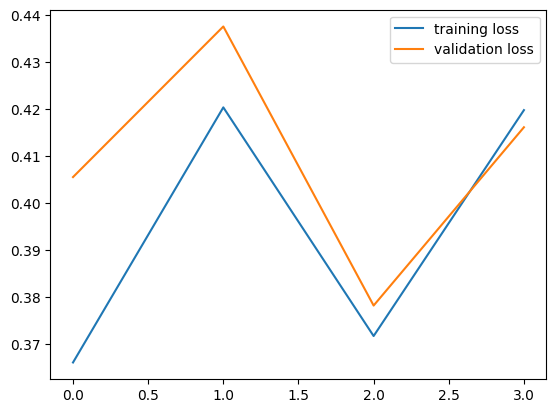

In [22]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(['training loss', 'validation loss'])
plt.show()

## Notes

### Training results with different parameters:

| Pretrained Model |`T`| Model Structure | Epochs | Training Loss | Validation Loss |
| ---------- | - | --------------- | ------ | ------------- | --------------- |
| CodeBERTa Small v1 | 0.07 | TFM → mean pool → MLP w/ batchnorm | - | ~1.6 | - |
| CodeBERTa Small v1 | 0.07 | TFM → lin1 → lin2 → MLP w/ batchnorm → max pool | - | ~1.4 | - |
| CodeBERTa Small v1 | 0.50 | (frozen) TFM's pooler output → layernorm → lin1 → lin2 → MLP  | 6 |  ~1.5 | ~1.35 |

`T` is the temperature hyperparameter of the NTXent loss function.

### Data TODOs
- ❎ - A lot of codes snippets mined from github can't be minified, filter unlabeled code dataset!

### Model TODOs
- ❎ - Try training with transformer's `pooler_output`
- ❎ - Fine-tuning the transformer